In [1]:
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import math

In [2]:
%matplotlib inline

In [3]:
matplotlib.get_configdir()

'/home/prateeks/.config/matplotlib'

In [4]:
#plt.style.use('plt-paper-style')

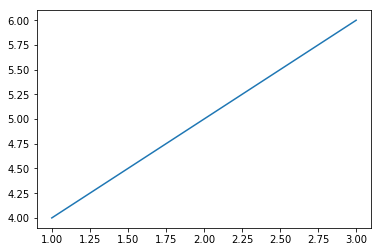

In [5]:
plt.plot([1,2,3],[4,5,6])

In [6]:
plt.show()

In [7]:
def Pfail(p,n):
    return 1.0-math.pow((1-p),n)

In [8]:
def ExpectedTime(T, MTTF, N):
    T = float(T)
    MTTF=float(MTTF)
    p = T/MTTF
    pf = Pfail(p, N)
    eT = T + ((T/2)*pf)
    return (eT, pf) 

In [9]:
ExpectedTime(1, 2, 1)

(1.25, 0.5)

In [10]:
par_speedup_1 = {1:1, 2:0.55, 4:0.3, 8:0.2, 16:0.15}
prices = {1:1, 2:2, 4:4, 8:8, 16:16,32:32,64:64} #Are always linear
#Keyed by server size
#mttfs = {1:14, 2:10, 4:10, 8:8, 16:7}
mttfs = {1:5, 2:5, 4:5, 8:5, 16:5, 32:4, 64:0.2}
 #Keyed by server size 

In [11]:
def SimuExpMemoryless(par_speedup, prices, mttfs):
    out = []
    for p in par_speedup.keys():
        T = par_speedup[p]
        eT, pfail = ExpectedTime(T, mttfs[p], p)
        recomputation = eT-T
        cost = eT*prices[p]
        out.append((p, eT, T, pfail, cost))
    
    times = out 
    x=zip(*times)[0]
    ets=zip(*times)[1]
    nofails=zip(*times)[2]
    pfails=zip(*times)[3]
    costs=zip(*times)[4]
    return (x, ets, nofails, pfails, costs)
    

In [126]:
(x, ets, nofails, pfails, costs) = SimuExpMemoryless(par_speedup_1, prices, mttfs)

In [128]:
def plot_all(par_speedup):
    (x, ets, nofails, pfails, costs) = SimuExpMemoryless(par_speedup, prices, mttfs)
    (fig1, ax) = plt.subplots(nrows=2, ncols=2)
    fig1.set_size_inches(10,8)
    ((ax1, ax2), (ax3, ax4)) = ax 
    ax1.scatter(x,ets,marker='x',label='Expected Time')
    ax1.scatter(x,nofails,color='r',label='Recomputation Time')
    ax1.set_ylim((0))
    ax1.grid()
    ax1.legend()
    
    #fig2, ax2 = plt.subplots(nrows=2, ncols=1)
    ax2.scatter(x,pfails,color='k',label='Failure Probability')
    ax2.legend()
    ax2.grid()
    
    #fig3, ax3 = plt.subplots()

    ax3.scatter(x, costs, label="Expected Cost")
    ax3.legend()
    ax3.grid()
    
    #fig4, ax4 = plt.subplots()
    ax4.scatter(x, np.array(costs)*np.array(ets), color='r', label="Cost/Speedup")
    ax4.legend()
    ax4.grid()

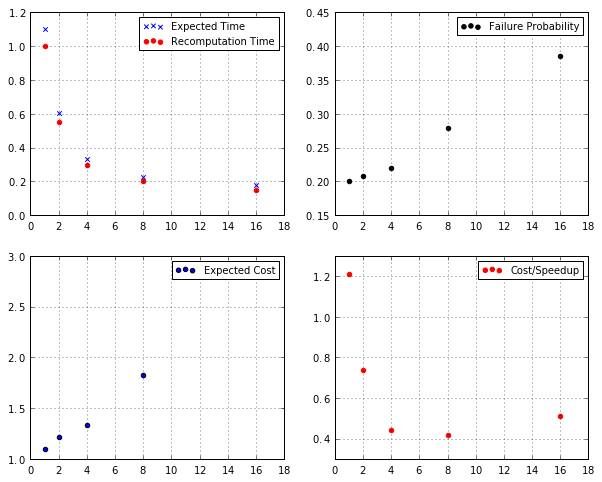

In [129]:
par_speedup_1 = {1:1, 2:0.55, 4:0.3, 8:0.2, 16:0.15}
plot_all(par_speedup_1)

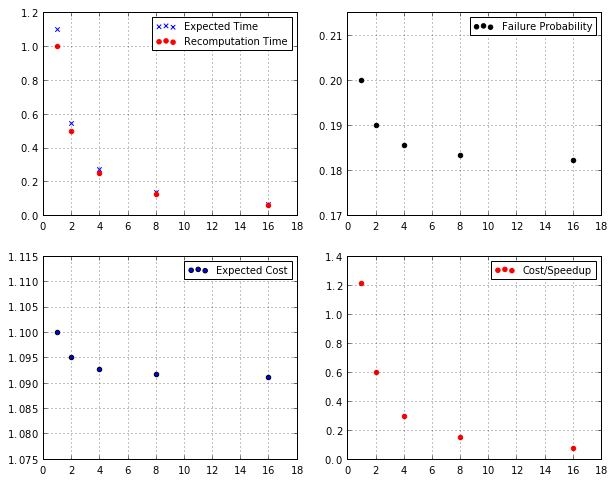

In [130]:
par_speedup_perfect = {1:1, 2:0.5, 4:0.25, 8:1.0/8, 16:1.0/16}
plot_all(par_speedup_perfect)

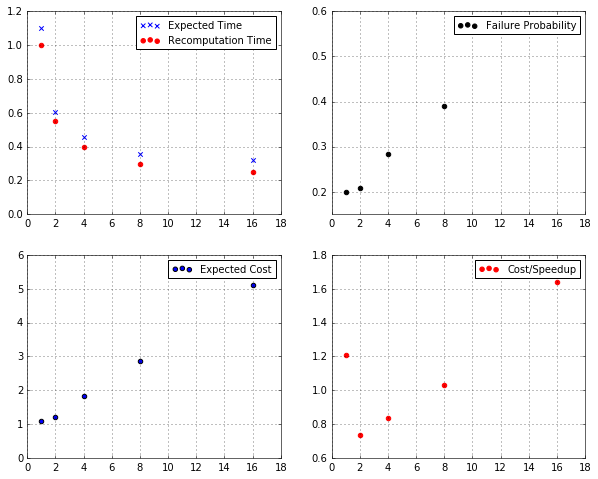

In [199]:
par_speedup_poor = {1:1, 2:0.55, 4:0.4, 8:0.3, 16:0.25}
plot_all(par_speedup_poor)

In [26]:
#confinement data

In [12]:
confinement_runtimes = {16:{16:30, 8:35, 4:37, 2:39}, 64:{64:11, 32:15, 16:15, 8:18, 4:21}}
#total_num_cpus:{server-cpus:run_time} 


In [13]:
lulesh_runtimes = {16:{16:30, 8:35, 4:37, 2:39}, 64:{64:0.5, 32:15, 16:15, 8:9, 4:21}}

In [14]:
shapes_runtimes = {16:{16:30, 8:35, 4:37, 2:39}, 64:{64:11, 32:9.6, 16:9, 8:9, 4:9}}


In [15]:
576/60.0

9.6

In [16]:
933/60.0

15.55

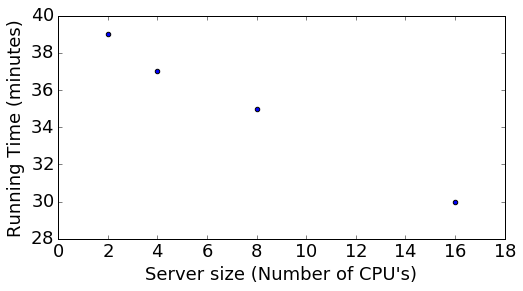

In [93]:
matplotlib.rcParams.update({'font.size': 18})
fig,ax=plt.subplots()
fig.set_size_inches(8,4)
runtimes = confinement_runtimes[16]
server_size = runtimes.keys()
r_minutes = runtimes.values()
ax.scatter(server_size, r_minutes)
ax.set_xlabel("Server size (Number of CPU's)")
ax.set_ylabel("Running Time (minutes)")
plt.savefig("../graphs/Confinement_explore_16.pdf",bbox_inches='tight')

In [22]:
def Exp_time_cost_memoryless(total_cpus, runtimes, prices, mttfs):
    #Assumes memoryless failures etc 
    out = []
    times = runtimes[total_cpus]
    
    for server_size in sorted(times.keys()):
        T = times[server_size]/60.0 
        num_servers = int(total_cpus/server_size) 
        eT, pfail = ExpectedTime(T, mttfs[server_size], num_servers)
        recomputation = eT-T
        cost = eT*prices[server_size]*num_servers
        ondem_cost = T*prices[server_size]*5*num_servers
        out.append((server_size, eT, T, pfail, cost, ondem_cost))
    
    times = out 
    all_outputs = list(zip(*times))
    x=all_outputs[0]
    ets=all_outputs[1]
    nofails=all_outputs[2]
    pfails=all_outputs[3]
    costs=all_outputs[4]
    ondem_costs=all_outputs[5]
    return (x, ets, nofails, pfails, costs, ondem_costs)

In [23]:
all_runtime_dict = dict()
apps=['NC','Shapes']
runtimes=[confinement_runtimes, shapes_runtimes]
for (a, r) in zip(apps, runtimes):
    (x, ets, nofails, pfails, costs, ondem_costs) = Exp_time_cost_memoryless(64, r, prices, mttfs)
    all_runtime_dict[a] = (x, ets, nofails, pfails, costs, ondem_costs)

In [24]:
all_runtime_dict

{'NC': ((4, 8, 16, 32, 64),
  (0.4702019347010997,
   0.3585646592188378,
   0.27318671875,
   0.26513671875,
   0.26736111111111105),
  (0.35, 0.3, 0.25, 0.25, 0.18333333333333332),
  (0.6868681982919986,
   0.3904310614589187,
   0.18549375000000012,
   0.12109375,
   0.9166666666666665),
  (30.092923820870382,
   22.94813819000562,
   17.48395,
   16.96875,
   17.111111111111107),
  (112.0, 96.0, 80.0, 80.0, 58.666666666666664)),
 'Shapes': ((4, 8, 16, 32, 64),
  (0.17893097599029859,
   0.1662192480421728,
   0.15860303925,
   0.166272,
   0.26736111111111105),
  (0.15, 0.15, 0.15, 0.16, 0.18333333333333332),
  (0.38574634653731454,
   0.2162566405623041,
   0.11470719000000007,
   0.07840000000000003,
   0.9166666666666665),
  (11.45158246337911,
   10.63803187469906,
   10.150594512,
   10.641408,
   17.111111111111107),
  (48.0, 48.0, 48.0, 51.2, 58.666666666666664))}

In [60]:
def plot_bars(all_runtime_dict):
    matplotlib.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots()
    fig.set_size_inches(8,5)
    w=0.2
    g=w
    #TODO: get the brc4 colors here!
    colors=['r', '0.6', 'b']
    for i,a in enumerate(all_runtime_dict.keys()):
        
        X=list(all_runtime_dict[a][0])
        ets=all_runtime_dict[a][1]
        nofails=all_runtime_dict[a][2]
        pfails=all_runtime_dict[a][3]
        costs=all_runtime_dict[a][4]
        ondem_costs=all_runtime_dict[a][5]
        recomputation_time = np.array(ets)-np.array(nofails)
        barlocs = np.arange(len(X))+(w*i)+g
        print(barlocs)
        ax.bar(barlocs, nofails, color=colors[i],lw=0.3, width=w, label=a)
        ax.bar(barlocs, recomputation_time, bottom=nofails,  color='k',lw=0.3,width=w,label='Recomputation' )
    
    
    
    ax.set_xlabel("Server Size (#CPUs)")
    ax.set_ylabel("Running Time (hours)")
    ax.set_xticks(np.arange(len(X))+w)
    ax.set_xticklabels(X)
    ax.set_xlim((-0.1))
    ax.legend()
    plt.savefig("../graphs/cost-bars.pdf",bbox_inches='tight')

[0.2 1.2 2.2 3.2 4.2]
[0.4 1.4 2.4 3.4 4.4]


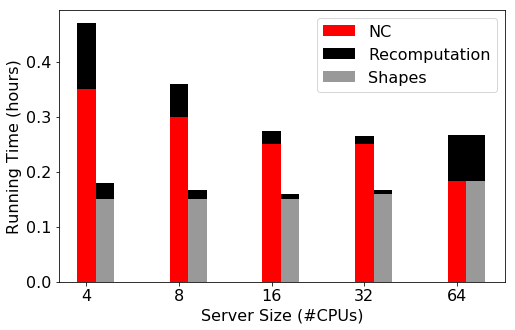

In [61]:
plot_bars(all_runtime_dict)

In [79]:
best_server_idx = 4 #Assume 32 is best for now always. TOFIX
median_server_idx = 2
def get_cost_comparison_data(all_runtime_dict):
    scispot_cost = []
    ondem_ss = []
    ondem_median = []
    
    for a in all_runtime_dict.keys():
        ets=all_runtime_dict[a][1]
        nofails=all_runtime_dict[a][2]
        pfails=all_runtime_dict[a][3]
        costs=all_runtime_dict[a][4]
        ondem_costs=all_runtime_dict[a][5]
        recomputation_time = np.array(ets)-np.array(nofails)

        scispot_cost.append(costs[best_server_idx])
        ondem_ss.append(ondem_costs[best_server_idx])
        ondem_median.append(ondem_costs[median_server_idx])
    
    return (scispot_cost, ondem_ss, ondem_median)
    

In [80]:
all_runtime_dict['NC'][4][0]

30.092923820870382

In [81]:
get_cost_comparison_data(all_runtime_dict)

([17.111111111111107, 17.111111111111107],
 [58.666666666666664, 58.666666666666664],
 [80.0, 48.0])

In [136]:
def plot_costs(all_runtime_dict):
    matplotlib.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots()
    fig.set_size_inches(8,5)
    w=0.05
    g=w
    #TODO: get the brc4 colors here!
    (scispot_cost, ondem_ss, ondem_median) = get_cost_comparison_data(all_runtime_dict)
    apps = all_runtime_dict.keys()
    X = np.arange(len(apps))
    #for (i, a) in enumerate(apps):
    barlocs = np.array(X + (1*w*1) + g) 
    ax.bar(barlocs, scispot_cost, width=w, label='SciSpot')
    ax.bar(barlocs+w+g, ondem_ss, width=w, label='On-demand with server selection' )
    ax.bar(barlocs+2*(w+g), ondem_median, width=w, label='On-demand on median server')
    ax.legend(loc='best')
    ax.set_xlabel("Application")
    ax.set_xticks(X+4*w)
    ax.set_xticklabels(apps)
    ax.set_ylabel("Cost per Job (cents)")
    plt.savefig("../graphs/cost-only-bar.pdf",bbox_inches='tight')

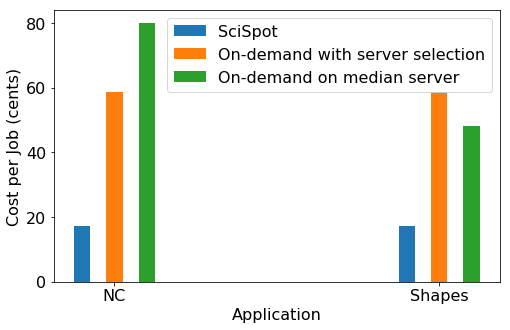

In [137]:
plot_costs(all_runtime_dict)

In [103]:
def plot_run_cost(num_cpus, wkload, runtime_data, prices, mttfs):
    (x, ets, nofails, pfails, costs, ondem_costs) = Exp_time_cost_memoryless(num_cpus, runtime_data, prices, mttfs)
    
    matplotlib.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots()
    fig.set_size_inches(8,4)
    ax.scatter(x, ets, label="Preemptible")
    ax.scatter(x, nofails, label="On-demand", color='r',marker='x')
    ax.set_xlabel("Server Size (Total number of CPUs={})".format(num_cpus))
    ax.set_ylabel("Running Time (Hours)")
    ax.legend(fontsize='small')
    fname = "../graphs/{}_{}_time.pdf".format(wkload, num_cpus)
    plt.savefig(fname, bbox_inches="tight")
    
    fig,ax=plt.subplots()
    fig.set_size_inches(8,4)
    ax.scatter(x, costs, label="Preemptible")
    ax.scatter(x, ondem_costs, label="On-demand", color='r',marker='x')
    ax.set_xlabel("Server Size (Total number of CPUs={})".format(num_cpus))
    ax.set_ylabel("Expected Cost per Job")
    ax.legend(fontsize='small')
    fname="../graphs/{}_{}_cost.pdf".format(wkload, num_cpus)
    plt.savefig(fname, bbox_inches="tight")


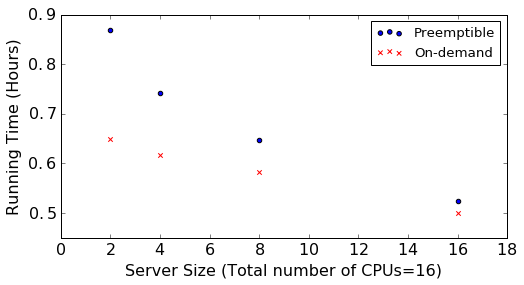

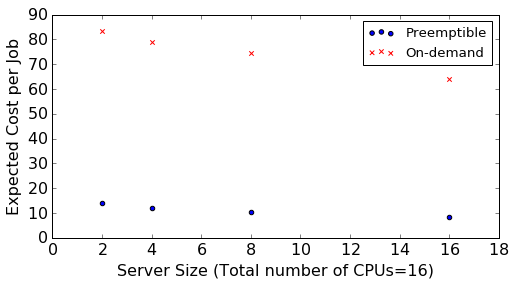

In [104]:
plot_run_cost(16, "confin", confinement_runtimes, prices, mttfs)

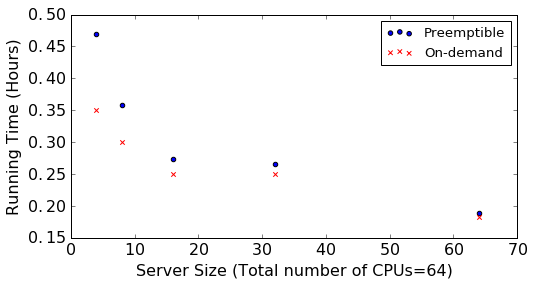

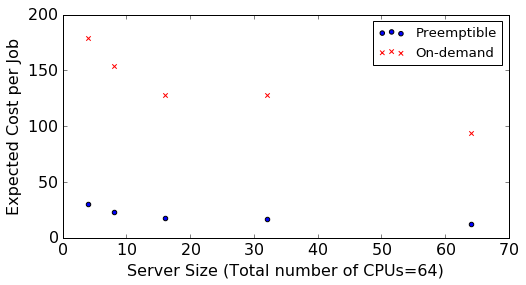

In [105]:
plot_run_cost(64, "confin", confinement_runtimes, prices, mttfs)